# Introduction to the float location forecast API

Argovis provides an API that indexes and distributes Argo float location forecast data provided by [citation needed]. The schema for these data is similar, but not identical, to many of our other products; this notebook will highlight some of the details specific to this dataset.

## Setup: Register an API key

In order to allocate Argovis's limited computing resources fairly, users are encouraged to register and request a free API key. This works like a password that identifies your requests to Argovis. To do so:

 - Visit [https://argovisbeta02.colorado.edu/api/](https://argovisbeta02.colorado.edu/api/)
 - Fill out the form under _New Account Registration_
 - An API key will be emailed to you shortly.
 
Treat this API key like a password - don't share it or leave it anywhere public. If you ever forget it or accidentally reveal it to a third party, see the same website above to change or deactivate your token.

Put your API key in the quotes in the variable below before moving on:

In [1]:
API_ROOT='https://argovisbeta01.colorado.edu/api/'
API_KEY=''

from argovisHelpers import helpers as avh
import xarray, pandas

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

# Float location forecast data structure

Let's begin by looking at a float location forecast document. The `forecastOrigin` key will query the forecast for a float starting at the provided longitude, latitude string, in this case `x0,y0`

In [2]:
x0 = 22
y0 = -44

flfSearch = {
    'forecastOrigin': str(x0) + ',' + str(y0),
    'data': 'all'
}

flf = avh.query('floatLocationForecast', options=flfSearch, apikey=API_KEY, apiroot=API_ROOT)
flf[1]

{'_id': '22_-44_24.0_-42.0',
 'metadata': ['covariance'],
 'geolocation': {'type': 'Point', 'coordinates': [22, -44]},
 'geolocation_forecast': {'type': 'Point', 'coordinates': [24, -42]},
 'data': {'90': [0.028571428571428577],
  '180': [0.014710588299395104],
  '270': [0.009351343578152089],
  '360': [0.00589899963455638],
  '450': [0.0039799151915137785],
  '540': [0.002804146487713185],
  '630': [0.0020765777548718573],
  '720': [0.0016263577818075943],
  '810': [0.0013443884987935741],
  '900': [0.0011628325893298147],
  '990': [0.0010364190410971936],
  '1080': [0.000951379086354582],
  '1170': [0.0008866986526338681],
  '1260': [0.0008372467539655549],
  '1350': [0.000797430682710675],
  '1440': [0.0007629238108195161],
  '1530': [0.0007331625096557775],
  '1620': [0.000706710105801801],
  '1710': [0.0006821935919922241],
  '1800': [0.000661199048205878]},
 'data_keys': ['90',
  '180',
  '270',
  '360',
  '450',
  '540',
  '630',
  '720',
  '810',
  '900',
  '990',
  '1080',
  '

We get an array of documents like the one illustrated above. These documents follow the conventions of Argovis' gridded documents, with the following modifications:

 - `geolocation` specifies the location of the float at the beginning of the forecast. Valid locations are lattice points of a 2 degree square grid centered on 0,0.
 - `geolocation_forecast` specifies the location of the float at the end of the forecast. These are populated over the same 2 degree grid as `geolocation`.
 - No `timestamp` key is present: these forecasts do not take into account seasonal or long term variations, and so have no meaningful timestamp to associate with them.
 - Data variables cover [90,1800] in steps of 90, and indicate number of days each forecast point covers. For example, if x0 = 22 and y0 = -44 were indicated in the previous code cell (as origin of interest), the above document indicates that a float initially at x0,y0 will have a 2.857% chance of being found in the 24,-42 grid cell after 90 days, or 0.066% after 1800 days.
 
The array of documents `flf` found above contains a document for every possible destination endpoint, for all 20 timesteps. The `floatLocationForecast` endpoint supports the same `data` query string behavior as other Argovis API endpoints (as always, see [https://argovisbeta01.colorado.edu/api/docs/](https://argovisbeta01.colorado.edu/api/docs/) for always-up-to-date API documentation for all routes). For example, let's get only the 90 day forecast:

In [3]:
flfSearch90 = {
    'forecastOrigin': str(x0) + ',' + str(y0),
    'data': '90'
}

flf90 = avh.query('floatLocationForecast', options=flfSearch90, apikey=API_KEY, apiroot=API_ROOT)
flf90[1]

{'_id': '22_-44_24.0_-42.0',
 'metadata': ['covariance'],
 'geolocation': {'type': 'Point', 'coordinates': [22, -44]},
 'geolocation_forecast': {'type': 'Point', 'coordinates': [24, -42]},
 'data': {'90': [0.028571428571428577]},
 'data_keys': ['90']}

We can also look backwards in time by querying all documents that have an endpoint of a given longitude, latitude with `forecastGeolocation`:

In [4]:
flfSearchReverse = {
    'forecastGeolocation':'24,-42',
    'data': 'all'
}

flfReverse = avh.query('floatLocationForecast', options=flfSearchReverse, apikey=API_KEY, apiroot=API_ROOT)
flfReverse[1]

{'_id': '-90_-56_24.0_-42.0',
 'metadata': ['covariance'],
 'geolocation': {'type': 'Point', 'coordinates': [-90, -56]},
 'geolocation_forecast': {'type': 'Point', 'coordinates': [24, -42]},
 'data': {'90': [None],
  '180': [None],
  '270': [None],
  '360': [None],
  '450': [None],
  '540': [None],
  '630': [None],
  '720': [None],
  '810': [None],
  '900': [None],
  '990': [None],
  '1080': [None],
  '1170': [None],
  '1260': [None],
  '1350': [None],
  '1440': [0.00010499539873719],
  '1530': [0.00024041753171309148],
  '1620': [0.0003787248381617915],
  '1710': [0.0005055899832310555],
  '1800': [0.000620739027433694]},
 'data_keys': ['90',
  '180',
  '270',
  '360',
  '450',
  '540',
  '630',
  '720',
  '810',
  '900',
  '990',
  '1080',
  '1170',
  '1260',
  '1350',
  '1440',
  '1530',
  '1620',
  '1710',
  '1800']}

We can also fairly easily turn this information into an xarray data set, and plot it:

In [5]:
def flfgrid(originlist):
    # given a list of documents from the argovis float location forecast API for a single float origin,
    # return an xarray object representing this data:

    lon = []
    lat = []
    forecastDays = []
    prob = []
    for doc in originlist:
        for key, value in doc['data'].items():
            lon.append(doc['geolocation_forecast']['coordinates'][0])
            lat.append(doc['geolocation_forecast']['coordinates'][1])
            forecastDays.append(int(key))
            prob.append(value[0])
            
    df = pandas.DataFrame({"latitude": lat, 
                           "longitude": lon, 
                           "forecastDays": forecastDays, 
                           "probability": prob
                          }).set_index(["latitude","longitude","forecastDays"])
    return df.to_xarray()
    

In [6]:
ds = flfgrid(flf)

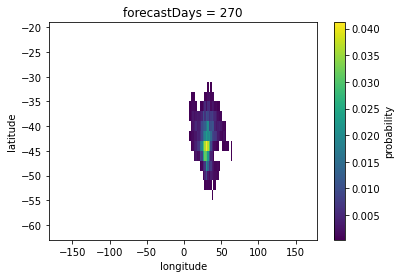

In [7]:
deltat_forecast = 270
gridmap = ds.loc[{"forecastDays":deltat_forecast}]
# x = ['black']*(12*30)
# x[37] = 'red'
# fig = gridmap['probability'].plot(edgecolors=x)
fig = gridmap['probability'].plot()

Or, we could turn it into numpy arrays and plot on a map (please note the x0, y0 origin we selected is indicated as a red star):

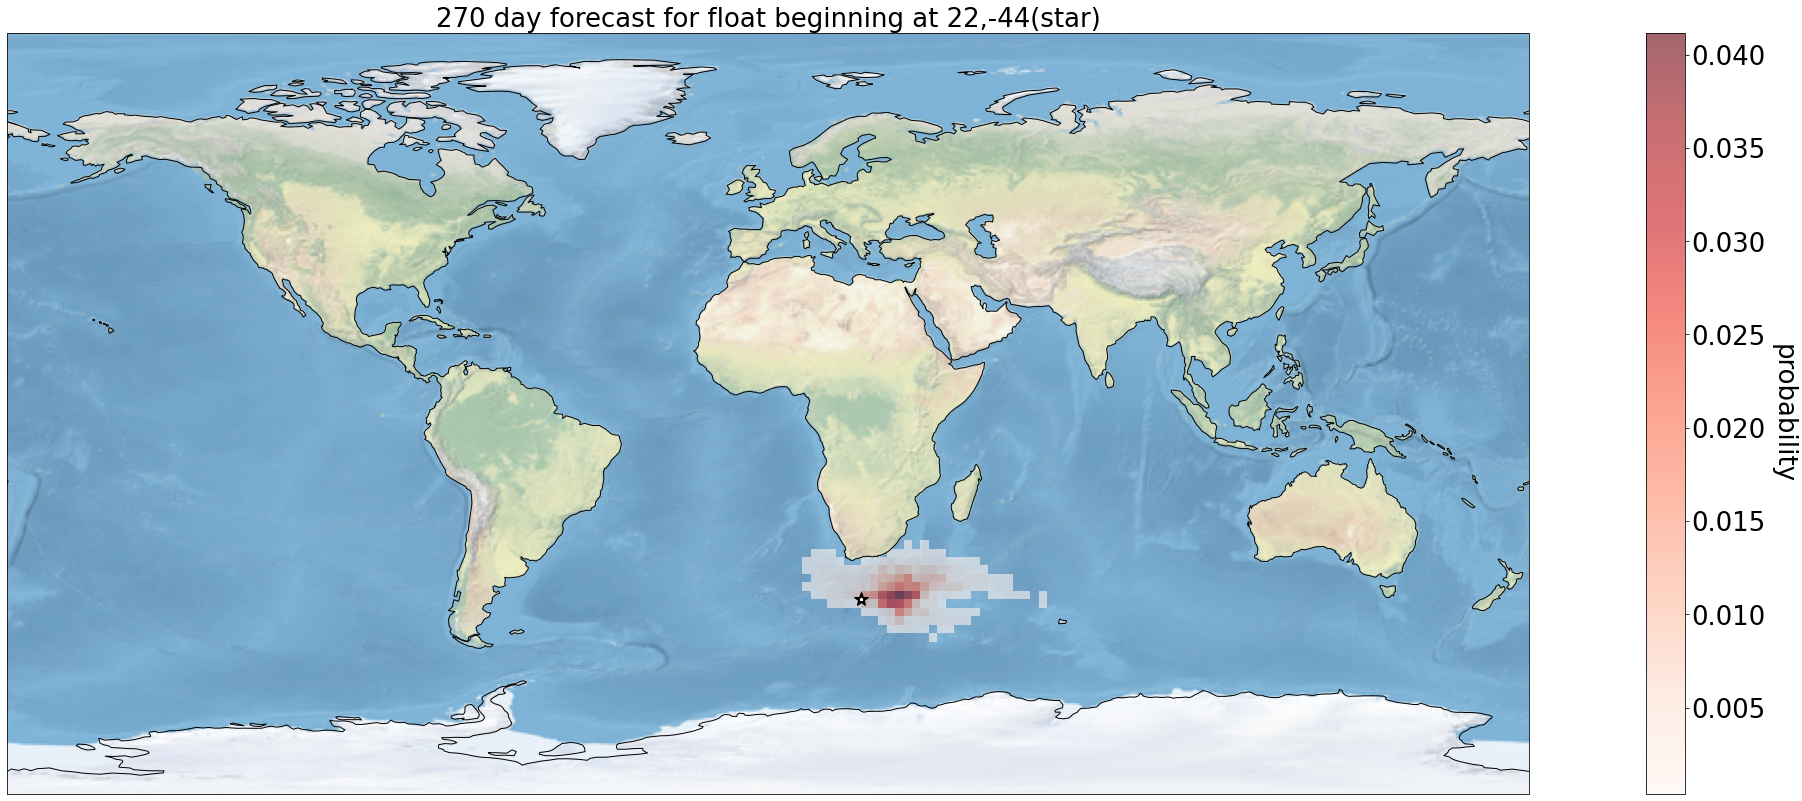

In [8]:
dlon = 2
dlat = 2

fnt_sz = 26

lon_edges = np.arange(-180,180+dlon,dlon)
lat_edges = np.arange(-90,90+dlat,dlat)

c = np.zeros((len(lat_edges),len(lon_edges)))
c[:] = None

def coord2bin(longitude, latitude):
    lonbin = np.argmax(lon_edges>longitude)
    latbin = np.argmax(lat_edges>latitude)
    return (latbin-1, lonbin-1)

for doc in flf:
    dest_long = doc['geolocation_forecast']['coordinates'][0]
    dest_lat = doc['geolocation_forecast']['coordinates'][1]
    coords = coord2bin(dest_long, dest_lat)
    c[coords[0], coords[1]] = doc['data'][str(deltat_forecast)][0]

fig = plt.figure(figsize=(42, 14))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lon_edges+dlon/2, lat_edges+dlat/2, c, transform=ccrs.PlateCarree(),cmap='Reds',
              alpha=.6)
cbar = plt.colorbar()
cbar.set_label('probability', rotation=270,fontsize=fnt_sz, labelpad=30)
cbar.ax.tick_params(labelsize=fnt_sz)

plt.plot(x0,y0,'*',markersize=15, color='k', transform=ccrs.PlateCarree())
plt.plot(x0,y0,'*',markersize=3, color='w', transform=ccrs.PlateCarree())

plt.title(str(deltat_forecast) + ' day forecast for float beginning at ' + str(x0) + ',' + str(y0) + '(star)',
          fontsize=fnt_sz)
ax.stock_img()
ax.coastlines()
plt.show()